In [1]:
#!rm -rf /root/ray_results/ /root/ray_results/PPO

In [2]:
!pip install /tensortrade -U
!pip3 uninstall -y  ray[default,tune,rllib,serve]==1.9.2
#!pip3 install gym==0.15.3
!pip3 install ccxt>=1.72.37
!pip3 install jupyterlab>=1.1.4
!pip3 install feature_engine
!pip3 install scikit-learn
!pip3 install optuna
!pip3 install tensorflow_probability
!pip3 install pandas
!pip3 install quantstats
#!pip3 install ray[default,tune,rllib,serve]==1.9.2
!pip3 install ray[default,tune,rllib,serve]
# ta>=0.4.7  # Broken metadata?
# TA-Lib  # Broken metadata?
!pip3 install pandas_ta

Processing /tensortrade
  Preparing metadata (setup.py) ... done


  Created wheel for tensortrade: filename=tensortrade-1.0.4.dev1-py3-none-any.whl size=136517 sha256=8c37831c2a09dfcb273099d3c7e2ddffeea1ae4953d18762044cb0af6c004e90
  Stored in directory: /tmp/pip-ephem-wheel-cache-euxn32iq/wheels/5c/80/0b/07e46799e19c54c3244190ea08f82534ab3fbdbd4fad3de846
Successfully built tensortrade
Found existing installation: ray 1.9.2
Uninstalling ray-1.9.2:
  Successfully uninstalled ray-1.9.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 14.8 MB/s eta 0:00:0000:0100:01


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 6.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 14.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.9/836.9 kB 15.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 23.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 9.5 MB/s eta 0:00:00


In [3]:
#!pip3 install gym==0.15.3

In [4]:
from tensortrade.data.cdd import CryptoDataDownload

import pandas as pd
import numpy as np

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp form "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

2023-03-04 04:15:19.140192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 04:15:19.813884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-04 04:15:19.813929: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-04 04:15:21.387759: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
import ta

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_features(data):
    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'date': 'Date', 
                                'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('Date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'dfast': data['Close'].rolling(window=10).std().abs(),
        'dmedium': data['Close'].rolling(window=50).std().abs(),
        'dslow': data['Close'].rolling(window=100).std().abs(),
        'fast': data['Close'].rolling(window=10).mean(),
        'medium': data['Close'].rolling(window=50).mean(),
        'slow': data['Close'].rolling(window=100).mean(),
        'ema_fast': ta.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_medium': ta.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_slow': ta.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'lr': np.log(data['Close']).diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_28': rsi(data['Close'], period=28),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Generate all default indicators from ta library
    ta.add_all_ta_features(data, 
                           'Open', 
                           'High', 
                           'Low', 
                           'Close', 
                           'Volume', 
                           fillna=True)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Date': 'date', 
                                'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    return data

In [6]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [7]:
data = fetch_data()
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.8,8793.0,8714.9,8739.0,8988053
1,2018-05-15 07:00 AM,8739.0,8754.8,8719.3,8743.0,2288904
2,2018-05-15 08:00 AM,8743.0,8743.1,8653.2,8723.7,8891773
3,2018-05-15 09:00 AM,8723.7,8737.8,8701.2,8708.1,2054868
4,2018-05-15 10:00 AM,8708.1,8855.7,8695.8,8784.4,17309722
...,...,...,...,...,...,...
42053,2023-03-02 08:00 PM,23473.0,23561.0,23440.0,23467.0,469479
42054,2023-03-02 09:00 PM,23471.0,23475.0,23402.0,23428.0,448507
42055,2023-03-02 10:00 PM,23428.0,23559.0,23428.0,23473.0,535865
42056,2023-03-02 11:00 PM,23474.0,23505.0,23451.0,23472.0,1559915


In [8]:
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.8,8793.0,8714.9,8739.0,8988053
1,2018-05-15 07:00 AM,8739.0,8754.8,8719.3,8743.0,2288904
2,2018-05-15 08:00 AM,8743.0,8743.1,8653.2,8723.7,8891773
3,2018-05-15 09:00 AM,8723.7,8737.8,8701.2,8708.1,2054868
4,2018-05-15 10:00 AM,8708.1,8855.7,8695.8,8784.4,17309722
...,...,...,...,...,...,...
42053,2023-03-02 08:00 PM,23473.0,23561.0,23440.0,23467.0,469479
42054,2023-03-02 09:00 PM,23471.0,23475.0,23402.0,23428.0,448507
42055,2023-03-02 10:00 PM,23428.0,23559.0,23428.0,23473.0,535865
42056,2023-03-02 11:00 PM,23474.0,23505.0,23451.0,23472.0,1559915


In [9]:
dataset = generate_features(data)
dataset

/usr/local/lib/python3.8/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,lr,rsi_5,rsi_10,rsi_100,rsi_7,rsi_14,rsi_28,macd_normal,macd_short,macd_long
0,7897.3,7898.8,7849.8,7877.4,9341499,-1.219515e+08,-153103304,-0.175983,-1.548039e+08,-1.586737e+04,...,-0.002523,54.694594,62.862413,58.177953,58.867381,65.249906,64.898857,11.190548,10.871904,31.873058
1,7877.4,7889.7,7661.0,7700.0,23679375,-1.375548e+08,-176782679,-0.228723,-7.327921e+08,-9.556783e+04,...,-0.022778,83.970505,78.146122,60.860099,80.595405,76.335665,71.316639,1.333779,-5.426751,34.355233
2,7700.0,7700.1,7548.1,7605.4,42144843,-1.479246e+08,-218927522,-0.216859,-1.197665e+09,-5.454997e+04,...,-0.012362,88.796304,82.430355,62.167022,85.395126,79.999761,73.950511,-10.060459,-21.497215,37.504922
3,7605.4,7623.6,7441.8,7511.1,38711817,-1.571235e+08,-257639339,-0.221424,-1.548073e+09,-4.292364e+04,...,-0.012477,91.852619,85.564709,63.397644,88.657814,82.850341,76.208878,-21.778972,-36.146245,41.269618
4,7511.1,7551.6,7403.0,7489.1,23046091,-1.534634e+08,-280685430,-0.149460,-1.399351e+09,-3.572163e+04,...,-0.002933,92.453006,86.202747,63.676078,89.307939,83.443225,76.697643,-28.422775,-41.976877,44.917996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41853,23473.0,23561.0,23440.0,23467.0,469479,8.975424e+09,-6600712637,-0.040058,-1.197761e+07,1.211343e+06,...,-0.000298,33.876658,45.304378,50.591804,40.102026,48.241754,49.887806,12.728174,18.004097,-13.235240
41854,23471.0,23475.0,23402.0,23428.0,448507,8.975295e+09,-6601161144,-0.027303,-1.276535e+07,-1.009126e+06,...,-0.001663,44.740788,49.465266,50.873005,46.893364,50.908142,51.044415,13.741665,15.963555,-12.923894
41855,23428.0,23559.0,23428.0,23473.0,535865,8.975127e+09,-6600625279,-0.040499,-7.496881e+06,1.344555e+06,...,0.001919,36.169588,45.069620,50.537772,40.683821,47.845359,49.672580,16.932232,18.289192,-13.057898
41856,23474.0,23505.0,23451.0,23472.0,1559915,8.974780e+09,-6602185194,-0.080033,-6.648743e+06,-5.365677e+04,...,-0.000043,36.507465,45.189882,50.545087,40.886761,47.920344,49.703731,18.345889,18.309499,-13.171450


In [10]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
X_train.to_csv(train_csv, index=False)
X_test.to_csv(test_csv, index=False)
X_valid.to_csv(valid_csv, index=False)

In [11]:
!pip install gymnasium

In [12]:
# Things to understand here:
# Writing a Renderer

import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):
    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        price = list(history.close)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = price[i]
                else:
                    sell[i] = price[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(price)), price, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

In [13]:
# Things to understand here:
# execution_order
# Types of execution logic
# Exchange
# DataFeed
# renderer_feed
# default (env)

import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.env.default.rewards import PBR, RiskAdjustedReturns
from tensortrade.env.default.rewards import SimpleProfit
from tensortrade.env.default.actions import BSH, ManagedRiskOrders
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.feed.core.base import NameSpace
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio

def create_env(config):
    data = pd.read_csv(filepath_or_buffer=config["csv_filename"], 
                       parse_dates=['date']).fillna(
                           method='backfill').fillna(method='ffill')

    # TODO: adjust according to your commission percentage, if present
    commission = 0.01
    price = Stream.source(list(data["close"]), 
                          dtype="float").rename("USD-BTC")
    bitstamp_options = ExchangeOptions(commission=commission)
    bitstamp = Exchange("bitstamp", 
                        service=execute_order, 
                        options=bitstamp_options)(price)

    cash = Wallet(bitstamp, 10000 * USD)
    asset = Wallet(bitstamp, 0 * BTC)

    portfolio = Portfolio(USD, [cash, asset])

    '''
    # Custom indicators
    features = pd.DataFrame.from_dict({
        'dfast': data['close'].rolling(window=10).std().abs(),
        'dmedium': data['close'].rolling(window=50).std().abs(),
        'dslow': data['close'].rolling(window=100).std().abs(),
        'fast': data['close'].rolling(window=10).mean(),
        'medium': data['close'].rolling(window=50).mean(),
        'slow': data['close'].rolling(window=100).mean(),
        'ema_fast': ta.trend.ema_indicator(data['close'], window=5, fillna=True),
        'ema_medium': ta.trend.ema_indicator(data['close'], window=10, fillna=True),
        'ema_slow': ta.trend.ema_indicator(data['close'], window=64, fillna=True),
        'lr': np.log(data['close']).diff().fillna(0),
        'rsi_5': rsi(data['close'], period=5),
        'rsi_10': rsi(data['close'], period=10),
        'rsi_100': rsi(data['close'], period=100),
        'rsi_7': rsi(data['close'], period=7),
        'rsi_14': rsi(data['close'], period=14),
        'rsi_28': rsi(data['close'], period=28),
        'macd_normal': macd(data['close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['close'], fast=200, slow=100, signal=50),
    })

    ta.add_all_ta_features(data, 
                           'open', 
                           'high', 
                           'low', 
                           'close', 
                           'volume', 
                           fillna=True)
    '''

    with NameSpace("bitstamp"):
        #data = pd.concat([data, features], axis='columns')
        automatic_features = [
            Stream.source(list(data[c]), 
                          dtype="float").rename(c) for c in data.columns[1:]
        ]

    feed = DataFeed(automatic_features)
    feed.compile()

    reward_scheme = PBR(price=price)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(list(data["date"])).rename("date"),
        Stream.source(list(data["open"]), dtype="float").rename("open"),
        Stream.source(list(data["high"]), dtype="float").rename("high"),
        Stream.source(list(data["low"]), dtype="float").rename("low"),
        Stream.source(list(data["close"]), dtype="float").rename("close"), 
        Stream.source(list(data["volume"]), dtype="float").rename("volume"), 
        Stream.sensor(action_scheme, 
                      lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=[
            PositionChangeChart(),
            default.renderers.PlotlyTradingChart(),
        ],
        window_size=config["window_size"],
        max_allowed_loss=0.9
    )
    return environment

ray.init(num_cpus=3,
         include_dashboard=True,
         address=None,  # set `address=None` to train on laptop
         ignore_reinit_error=True)

register_env("TradingEnv", create_env)

2023-03-04 04:15:38,917	WARNING services.py:1780 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 3221225472 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.99gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-03-04 04:15:39,101	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [14]:
!pip3 install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB ? eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 6.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB ? eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 24.6 MB/s eta 0:00:0000:0100:01


In [15]:
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.suggest.optuna import OptunaSearch
from ray import tune

LR = tune.loguniform(1e-5, 1e-2)
GAMMA = tune.uniform(0.8, 0.9999)
LAMBDA = tune.uniform(0.1, 0.8)
VF_LOSS_COEFF = tune.uniform(0.01, 1.0)
ENTROPY_COEFF = tune.uniform(1e-8, 1e-1)

checkpoint_metric = 'episode_reward_mean'

# Specific configuration keys that will be used during training
env_config_training = {
    "window_size": 14,  # The number of past samples we want to look at (in hours)
    "reward_window_size": 7,  # The number of hours we want to look at in the future to calculate the rewards based on the actions taken
    "max_allowed_loss": 0.90,  # If it goes past 90% loss during the iteration, we don't want to waste time on a "loser".
    "csv_filename": train_csv  # The variable that will be used to differentiate training and validation datasets
}
# Specific configuration keys that will be used during evaluation (only the overridden ones)
env_config_evaluation = {
    "max_allowed_loss": 1.00,  # During validation runs we want to see how bad it would go. Even up to 100% loss.
    "csv_filename": test_csv,  # The variable that will be used to differentiate training and validation datasets
}

search_alg = OptunaSearch()
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=4)

scheduler = ASHAScheduler()

import time
start = time.time()
analysis = tune.run(
    "PPO",
    stop={
        "episode_reward_mean": 5000,
        "training_iteration": 35,
    },
    config={
        "env": "TradingEnv",
        "env_config": env_config_training,
        "log_level": "ERROR",
        #"log_level": "INFO",
        #"log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": LR,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "model": {
            "_use_default_native_models": False,
            "use_attention": True,
            "max_seq_len": 10,
            "attention_num_transformer_units": 1,
            "attention_dim": 32,
            "attention_memory_inference": 10,
            "attention_memory_training": 10,
            "attention_num_heads": 1,
            "attention_head_dim": 32,
            "attention_position_wise_mlp_dim": 32,
        },
        "gamma": GAMMA,
        "observation_filter": "MeanStdFilter",
        "lambda": LAMBDA,
        "num_envs_per_worker": 20,
        "vf_share_layers": True,
        "vf_loss_coeff": VF_LOSS_COEFF,
        "entropy_coeff": ENTROPY_COEFF,
        "num_sgd_iter": 10,
        "evaluation_interval": 1,  # Run evaluation on every iteration
        "evaluation_config": {
            "env_config": env_config_evaluation,  # The dictionary we built before (only the overriding keys to use in evaluation)
            "explore": False,  # We don't want to explore during evaluation. All actions have to be repeatable.
        },
    },
    metric=checkpoint_metric,
    mode="max",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=1,  # Samples per hyperparameter combination. More averages out randomness. Less runs faster
    #resources_per_trial={"cpu": 1},
    keep_checkpoints_num=10,  # Keep the last 10 checkpoints
    checkpoint_freq=1,  # Do a checkpoint on each iteration (slower but you can pick more finely the checkpoint to use later)
    resume="AUTO",
)
taken = time.time() - start
print(f"Time taken: {taken:.2f} seconds.")
print(f"Best config: {analysis.best_config}")

/tmp/ipykernel_16/2346501884.py:2: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
  from ray.tune.suggest import ConcurrencyLimiter
/tmp/ipykernel_16/2346501884.py:3: DeprecationWarning: The module `ray.tune.suggest.optuna` has been moved to `ray.tune.search.optuna` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest.optuna` with `ray.tune.search.optuna`.
  from ray.tune.suggest.optuna import OptunaSearch
/usr/local/lib/python3.8/dist-packages/ray/tune/search/optuna/optuna_search.py:662: FutureWarning: LogUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :c

2023-03-04 04:21:55,971	INFO trial_runner.py:640 -- No local checkpoint was found. Ray Tune will now start a new experiment.
/usr/local/lib/python3.8/dist-packages/optuna/distributions.py:799: FutureWarning: LogUniformDistribution(high=0.01, low=1e-05) is deprecated and internally converted to FloatDistribution(high=0.01, log=True, low=1e-05, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.8/dist-packages/optuna/distributions.py:799: FutureWarning: UniformDistribution(high=0.9999, low=0.8) is deprecated and internally converted to FloatDistribution(high=0.9999, log=False, low=0.8, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.8/dist-packages/optuna/distributions.py:799: FutureWarning: UniformDistribution(high=0.8, low=0.1) is deprecated and internally converted to FloatDistribution(high=0.8, log=False, low=0.1, step=None). See https

Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,evaluation,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
PPO_TradingEnv_479afc47,140000,"{'ClipRewardAgentConnector_ms': 0.018682479858398438, 'ObsPreprocessorConnector_ms': 0.012016534805297852, 'MeanStdObservationFilterAgentConnector_ms': 0.08233523368835449, 'StateBufferConnector_ms': 0.01546621322631836, 'ViewRequirementAgentConnector_ms': 0.1845378875732422}","{'num_env_steps_sampled': 140000, 'num_env_steps_trained': 140000, 'num_agent_steps_sampled': 140000, 'num_agent_steps_trained': 140000}",{},2023-03-04_04-33-35,True,543.98,{},413,331.44,253,2,240,"{'episode_reward_max': 32.0, 'episode_reward_min': 32.0, 'episode_reward_mean': 32.0, 'episode_len_mean': 569.0, 'episode_media': {}, 'episodes_this_iter': 10, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0], 'episode_lengths': [569, 569, 569, 569, 569, 569, 569, 569, 569, 569]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 10.2290856210809, 'mean_inference_ms': 3.999075533761792, 'mean_action_processing_ms': 3.3450863164555846, 'mean_env_wait_ms': 10.121158913966955, 'mean_env_render_ms': 0.0}, 'num_faulty_episodes': 0, 'connector_metrics': {'ClipRewardAgentConnector_ms': 0.023665428161621094, 'ObsPreprocessorConnector_ms': 0.03124237060546875, 'MeanStdObservationFilterAgentConnector_ms': 0.11253118515014648, 'StateBufferConnector_ms': 0.05151033401489258, 'ViewRequirementAgentConnector_ms': 0.373995304107666}, 'num_agent_steps_sampled_this_iter': 5690, 'num_env_steps_sampled_this_iter': 5690, 'timesteps_this_iter': 5690, 'num_healthy_workers': 0, 'num_in_flight_async_reqs': 0, 'num_remote_worker_restarts': 0}",84985e83b6ae40f6aa3190cea9d7dda2,d2184c4e371f,"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.7868880696835057, 'cur_kl_coeff': 0.14238281249999998, 'cur_lr': 9.64e-06, 'total_loss': 0.05925351916737254, 'policy_loss': -0.038129633420331016, 'vf_loss': 0.4456483213170882, 'vf_explained_var': 0.587371281846877, 'kl': 0.004629993660848648, 'entropy': 0.2095425609138704, 'entropy_coeff': 0.022133133561933405}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 127.74193548387096, 'num_grad_updates_lifetime': 10695.5, 'diff_num_grad_updates_vs_sampler_policy': 154.5}}, 'num_env_steps_sampled': 140000, 'num_env_steps_trained': 140000, 'num_agent_steps_sampled': 140000, 'num_agent_steps_trained': 140000}",35,172.17.0.2,140000,140000,140000,4000,140000,4000,0,2,0,0,4000,"{'cpu_util_percent': 63.43428571428569, 'ram_util_percent': 28.12285714285715}",479,{},{},{},"{'mean_raw_obs_processing_ms': 12.093935767029588, 'mean_inference_ms': 4.383893189708184, 'mean_action_processing_ms': 3.5322118060780268, 'mean_env_wait_ms': 12.884304931142214, 'mean_env_render_ms': 0.0}","{'episode_reward_max': 413.0, 'episode_reward_min': 253.0, 'episode_reward_mean': 331.44, 'episode_len_mean': 543.98, 'episode_media': {}, 'episodes_this_iter': 2, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [298.0, 297.0, 291.0, 306.0, 304.0, 321.0, 282.0, 288.0, 284.0, 267.0, 277.0, 303.0, 253.0, 2

/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
2023-03-04 04:33:35,716	INFO tune.py:798 -- Total run time: 706.52 seconds (699.50 seconds for the tuning loop).


Time taken: 706.76 seconds.
Best config: {'env': 'TradingEnv', 'env_config': {'window_size': 14, 'reward_window_size': 7, 'max_allowed_loss': 0.9, 'csv_filename': '/examples/train.csv'}, 'log_level': 'ERROR', 'framework': 'torch', 'ignore_worker_failures': True, 'num_workers': 2, 'num_gpus': 0, 'clip_rewards': True, 'lr': 0.0008697338388634734, 'lr_schedule': [[0, 0.1], [100, 0.01], [1000, 0.001], [10000, 0.0001], [100000, 1e-05], [1000000, 1e-06], [10000000, 1e-07]], 'model': {'_use_default_native_models': False, 'use_attention': True, 'max_seq_len': 10, 'attention_num_transformer_units': 1, 'attention_dim': 32, 'attention_memory_inference': 10, 'attention_memory_training': 10, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_position_wise_mlp_dim': 32}, 'gamma': 0.8728656578907852, 'observation_filter': 'MeanStdFilter', 'lambda': 0.37733518280269185, 'num_envs_per_worker': 20, 'vf_share_layers': True, 'vf_loss_coeff': 0.22744785053064162, 'entropy_coeff': 0.022133133561

In [16]:
!rm -r -f /root/ray_results/PPO

In [17]:
!ls -ltr /root/ray_results/PPO/*

ls: cannot access '/root/ray_results/PPO/*': No such file or directory


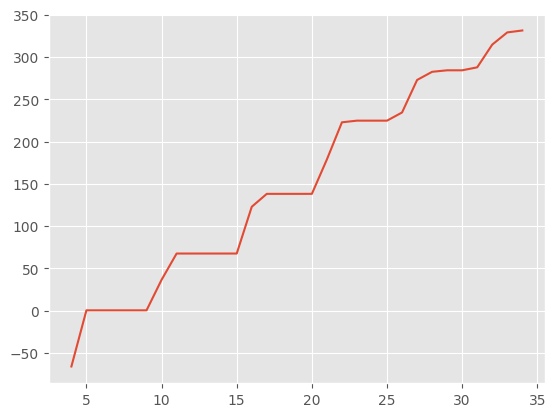

In [20]:
dfs = analysis.trial_dataframes

ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.episode_reward_mean.plot(ax=ax, legend=False)

In [ ]:
import ray.rllib.agents.ppo as ppo

# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(checkpoint_metric, mode='max'),
    metric=checkpoint_metric
)
checkpoint_path = checkpoints[0][0]

env_config_validation = {
    "window_size": 14,  # The number of past samples we want to look at (in hours)
    "reward_window_size": 7,  # The number of hours we want to look at in the future to calculate the rewards based on the actions taken
    "max_allowed_loss": 1.0,  # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
    "csv_filename": valid_csv  # The variable that will be used to differentiate training and validation datasets
}

config = analysis.get_best_config(checkpoint_metric, mode='max')
config['env_config'] = env_config_validation

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config=config,
)

agent.restore(checkpoint_path)

(autoscaler +27m34s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +27m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +28m9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +28m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +29m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due t

In [ ]:
# See how the model is wrapped by LSTM
agent.get_policy().model

In [ ]:
# Instantiate the environment
env = create_env(env_config_validation)

# Run until episode ends
done = False
obs = env.reset()
total_reward = 0

# start with all zeros as state
num_transformers = config["model"][
    "attention_num_transformer_units"]
attention_dim = config["model"]["attention_dim"]
memory = config["model"]["attention_memory_inference"]
init_state = state = [
    np.zeros([memory, attention_dim], np.float32)
    for _ in range(num_transformers)
]

# run one iteration until done
print(f"TradingEnv with {agent.config['env_config']}")
while not done:
    action, state_out, _ = agent.compute_single_action(
        obs, state)
    next_obs, reward, done, info = env.step(action)
    print(f"Obs: {obs}, Action: {action}, Reward: {reward}")
    obs = next_obs
    total_reward += reward
    state = [
        np.concatenate([state[i], [state_out[i]]], axis=0)[1:]
        for i in range(num_transformers)
    ]
print(f"Total reward in test episode: {total_reward}")

env.render()